# BiGAN Performance Visualization

For each dataset, we basically want to know two things:
- The reconstruction ability.
- Use the latent space representation to perform downstream task such as classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# some utility functions
def visualize_grid_tensor(tensor):
    """ Visualize tensor in a grid """
    tensor = tensor.detach().numpy()
    tensor = tensor.transpose((0, 2, 3, 1))
    grid = viz_grid(tensor).squeeze()
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='gray')

## MNIST

In [3]:
from bigan_ali_mnist import Discriminator, Generator, Encoder, ALI, weights_init_normal
import torch.nn as nn
import torch
from itertools import chain
from lib.utils.plot_utils import viz_grid

In [4]:
code_size = 64
validity_loss_f = nn.BCELoss()
lr_D = 1e-4
lr_G = 1e-4
minibatch_norm = False
checkpoint_path = './checkpoint/bigan_ali_mnist.ckpt'
weight_norm = None

# models
discriminator = Discriminator(code_size=code_size, weight_init=weights_init_normal, weight_norm=weight_norm)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr_D, betas=(0.5, 0.999))

generator = Generator(code_size=code_size, weight_init=weights_init_normal, weight_norm=weight_norm)
encoder = Encoder(code_size=code_size, weight_init=weights_init_normal, weight_norm=weight_norm)
optimizer_G = torch.optim.Adam(chain(generator.parameters(), encoder.parameters()), lr_G, betas=(0.5, 0.999))

gan_model = ALI(generator, encoder, discriminator, optimizer_G, optimizer_D, code_size, validity_loss_f)
gan_model.load_checkpoint(checkpoint_path, all=False)

Loading checkpoint from ./checkpoint/bigan_ali_mnist.ckpt


In [5]:
# generate some samples
n_row = 10
output_images = (gan_model.generate('num', n_row * n_row) + 1.) / 2.

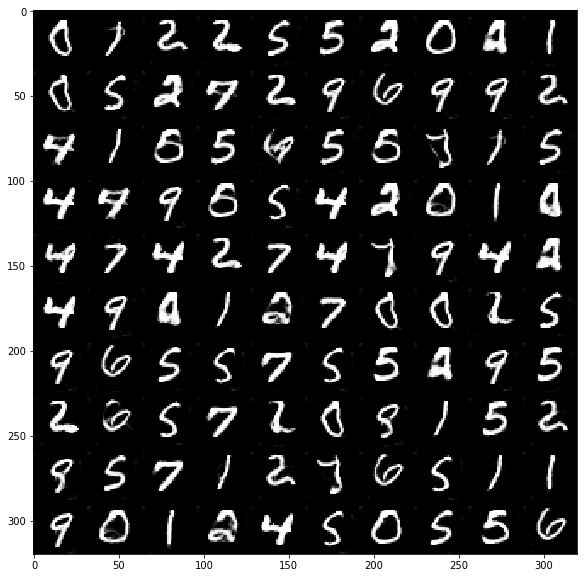

In [6]:
visualize_grid_tensor(output_images)

Comment:
- This trained model suffer from mode collapse. It's clear that digit eight (8) is missing.
- Mode collapse is also reflected by the same shape of the same digit.
- Maybe we should use semi-supervised approach by incorporating some labels.

In [7]:
# get some real data
from lib.dataset.mnist import get_mnist_data_loader

In [8]:
data_loader = get_mnist_data_loader(train=True, batch_size=100)

In [9]:
mnist_data = next(iter(data_loader))

In [10]:
data, label = mnist_data

In [11]:
# generate latent space
latent = gan_model.inference(data).detach().numpy()

In [12]:
reconstruction = gan_model.generate('fixed', latent)

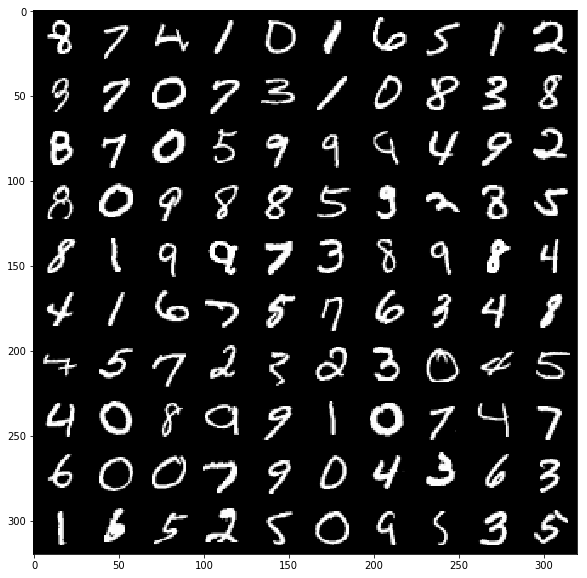

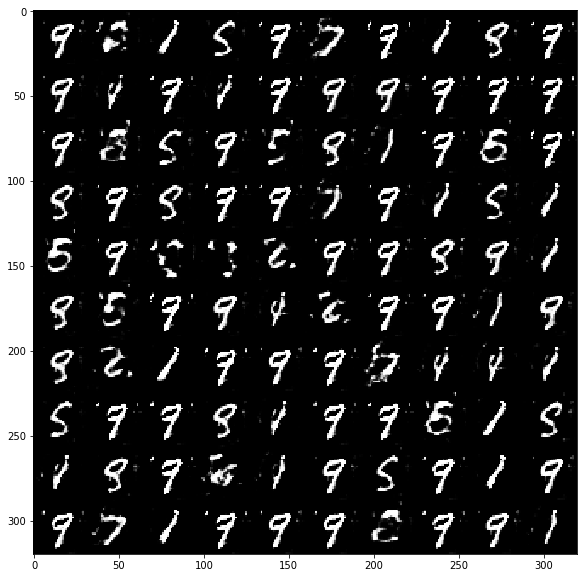

In [13]:
visualize_grid_tensor(data)
visualize_grid_tensor(reconstruction)

Insights:
- The current problem is that the latent space range differs from the prior distribution. It means BiGAN fails to catch the joint distribution of (X, z).
- BiGAN is really hard to train because of the mode collapse issue.